<a href="https://colab.research.google.com/github/tlr-id/MIR2023/blob/main/MidProjMIR_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# You know

### Setup

In [ ]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 25.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=5fbd00862746e0bfd9bc2d5fbd756fc14a1a4e6b83582af680d65996b1060405
  Stored in directory: /root/.cache

### Dataset handling

In [ ]:
beatport_key = mirdata.initialize("beatport_key")
beatport_key.download()
beatport_key.validate()  # validate dataset

376kB [00:01, 219kB/s]                           
904kB [00:01, 508kB/s]                           
1.98GB [01:23, 25.6MB/s]                            
100%|██████████| 1486/1486 [00:06<00:00, 219.86it/s]


({'tracks': {}}, {'tracks': {}})

In [ ]:
import IPython.display as ipd

track = beatport_key.choice_track()  # load a random track
x, sr = track.audio

print(track.audio_path)
ipd.display(ipd.Audio(data='..' + track.audio_path, rate=44100))
print(track)  # see what data a track contains

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


/root/mir_datasets/beatport_key/audio/650341 Phun-tastik - Pizzicato Passion (Radio Edit).mp3


In [ ]:
beatport_ids = beatport_key.track_ids
beatport_data = beatport_key.load_tracks()

Track(
  audio_path="/root/mir_datasets/beatport_key/audio/650341 Phun-tastik - Pizzicato Passion (Radio Edit).mp3",
  keys_path="/root/mir_datasets/beatport_key/keys/650341 Phun-tastik - Pizzicato Passion (Radio Edit).txt",
  metadata_path=None,
  title="650341 Phun-tastik - Pizzicato Passion (Radio Edit)",
  track_id="1368",
  artists: ,
  audio: The track's audio

        Returns,
  genres: ,
  key: ,
  tempo: ,
)


In [ ]:

print(beatport_key.load_genre(beatport_data['487'].metadata_path))
print(beatport_data['488'])
print(beatport_data['488'].key)
print(beatport_data['488'].genres)
print(beatport_data['488'].tempo)
print(len(beatport_data))

None
Track(
  audio_path="...eatport_key/audio/298193 Marschmellows, Sugar B. - Swoundosophy feat. Sugar B. (Moodorama Remix).mp3",
  keys_path="...beatport_key/keys/298193 Marschmellows, Sugar B. - Swoundosophy feat. Sugar B. (Moodorama Remix).txt",
  metadata_path="...eatport_key/meta/298193 Marschmellows, Sugar B. - Swoundosophy feat. Sugar B. (Moodorama Remix).json",
  title="298193 Marschmellows, Sugar B. - Swoundosophy feat. Sugar B. (Moodorama Remix)",
  track_id="488",
  artists: ,
  audio: The track's audio

        Returns,
  genres: ,
  key: ,
  tempo: ,
)
['G minor']
{'genres': ['House'], 'sub_genres': []}
120
1486


<ipython-input-8-ed6d9052369c>:1: DeprecationWarning: Call to deprecated method load_genre. (Use mirdata.datasets.beatport_key.load_genre) -- Deprecated since version 0.3.4.
  print(beatport_key.load_genre(beatport_data['487'].metadata_path))


In [ ]:
list_tracks = []
for i in beatport_data:
  if beatport_data[str(i)].metadata_path != None:
    #print(beatport_data[str(i)])
  #if beatport_data[str(i)].genres['genres'][0] != None:
    list_tracks.append(beatport_data[str(i)])

    #print(beatport_data[str(i)].genres['genres'][0])

print(len(list_tracks))
print(list_tracks[0].genres['genres'][0])
print(list_tracks[0].audio_path)

792
Electronica / Downtempo
/root/mir_datasets/beatport_key/audio/100066 Lindstrom - Monsteer (Original Mix).mp3


In [ ]:
# List of uniques genres

genre_names = []
for i in list_tracks:
  tmp = i.genres['genres']
  if len(tmp) > 1:
    print("--- Error ; shouldn't happen")
    break                        
  genre_names.append(tmp[0])

genre_names_unique = np.unique(genre_names)
print(genre_names_unique)

['Big Room' 'Breaks' 'Deep House' 'Drum & Bass' 'Dubstep' 'Electro House'
 'Electronica / Downtempo' "Funky / Groove / Jackin' House" 'Hard Dance'
 'Hip-Hop / R&B' 'House' 'Minimal / Deep Tech' 'Progressive House'
 'Psy-Trance' 'Tech House' 'Techno' 'Trance']


In [ ]:
genre_dict = {item: [] for item in genre_names_unique}
print(genre_dict)

for i in list_tracks:
  genre_dict[i.genres['genres'][0]].append(i)

for i in genre_dict:
  print(f'Number of elements for {i} : {len(genre_dict.get(i))}')

{'Big Room': [], 'Breaks': [], 'Deep House': [], 'Drum & Bass': [], 'Dubstep': [], 'Electro House': [], 'Electronica / Downtempo': [], "Funky / Groove / Jackin' House": [], 'Hard Dance': [], 'Hip-Hop / R&B': [], 'House': [], 'Minimal / Deep Tech': [], 'Progressive House': [], 'Psy-Trance': [], 'Tech House': [], 'Techno': [], 'Trance': []}
Number of elements for Big Room : 1
Number of elements for Breaks : 49
Number of elements for Deep House : 48
Number of elements for Drum & Bass : 41
Number of elements for Dubstep : 41
Number of elements for Electro House : 54
Number of elements for Electronica / Downtempo : 99
Number of elements for Funky / Groove / Jackin' House : 8
Number of elements for Hard Dance : 54
Number of elements for Hip-Hop / R&B : 51
Number of elements for House : 44
Number of elements for Minimal / Deep Tech : 54
Number of elements for Progressive House : 50
Number of elements for Psy-Trance : 43
Number of elements for Tech House : 49
Number of elements for Techno : 52

In [ ]:
# Balancing & randomizing when too much elems : 
import random
balanced_genre_dict = {}
files_list = []

for i in genre_dict:
  #print(i)
  if i in {'Big Room', 'Funky / Groove / Jackin\' House'}:
    print(f"This genre : {i} is discarded.")
    pass
  else:
    balanced_genre_dict[i] = random.sample(genre_dict.get(i),41)

genre_dict = balanced_genre_dict

for i in genre_dict:
  print(f'Number of elements for {i} : {len(genre_dict.get(i))}')
  [files_list.append(j) for j in genre_dict.get(i)]


print(f'We have {len(files_list)} files for {len(genre_dict)} different classes')
print(files_list[0])

Number of elements for Breaks : 41
Number of elements for Deep House : 41
Number of elements for Drum & Bass : 41
Number of elements for Dubstep : 41
Number of elements for Electro House : 41
Number of elements for Electronica / Downtempo : 41
Number of elements for Hard Dance : 41
Number of elements for Hip-Hop / R&B : 41
Number of elements for House : 41
Number of elements for Minimal / Deep Tech : 41
Number of elements for Progressive House : 41
Number of elements for Psy-Trance : 41
Number of elements for Tech House : 41
Number of elements for Techno : 41
Number of elements for Trance : 41
We have 615 files for 15 different classes
Track(
  audio_path="...root/mir_datasets/beatport_key/audio/861422 Romanto, Out Of The Drum - The Guitar (Original Mix).mp3",
  keys_path="/root/mir_datasets/beatport_key/keys/861422 Romanto, Out Of The Drum - The Guitar (Original Mix).txt",
  metadata_path="...root/mir_datasets/beatport_key/meta/861422 Romanto, Out Of The Drum - The Guitar (Original Mi

# Preprocessing

In [ ]:
print(genre_dict['Breaks'][0].audio_path)

/root/mir_datasets/beatport_key/audio/861422 Romanto, Out Of The Drum - The Guitar (Original Mix).mp3


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Plot waveforms of random samples of each genre type...


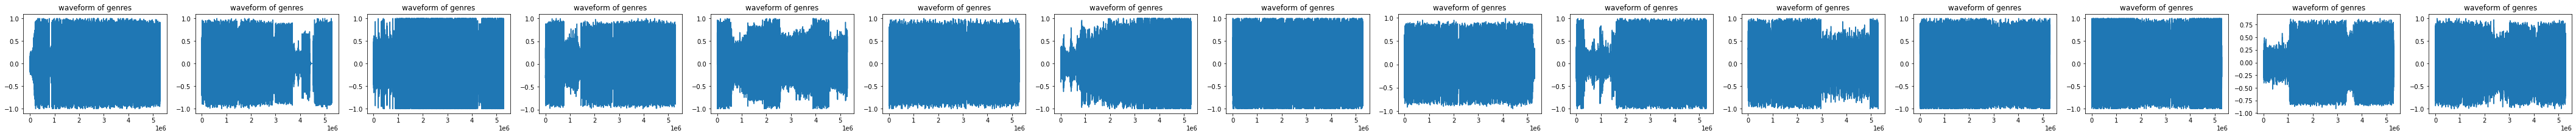

In [ ]:
# Raw-data preprocess analysis parameters
_, fs = beatport_data[beatport_ids[0]].audio

num_genres = len(genre_dict.keys())
print("Plot waveforms of random samples of each genre type...")
plt.figure(1, figsize=(5 * num_genres, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, genre in enumerate(genre_dict.keys()):
    sample_file = genre_dict[genre][file_ind_inlist].audio_path
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_genres,(i+1))
    plt.plot(x)
    plt.title('waveform of genres')   

Working on 2mn fragments of audio. 
FOR NOW, keeping this length ; not segmenting splitting or aligning 

What we can do is to devide the 2mn audio in 4 30s files ??? We will see. 

## Feature extraction

Using Essentia ; 
Using only one data for our entire song -> making mean on the entire song if needed.

-> extracting low level features ; adding BPM & key
Having genre added

In [ ]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(beatport_data[beatport_ids[10]].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
files_test = random.sample(files_list,10)
#print(files_test)
print(len(files_test))
print(files_test[0])
print(files_test[0].genres['genres'][0])




10
Track(
  audio_path="...ot/mir_datasets/beatport_key/audio/299870 Harlem Hustler - U Can Do It (Harlem Hustler Club Mix).mp3",
  keys_path="...oot/mir_datasets/beatport_key/keys/299870 Harlem Hustler - U Can Do It (Harlem Hustler Club Mix).txt",
  metadata_path="...ot/mir_datasets/beatport_key/meta/299870 Harlem Hustler - U Can Do It (Harlem Hustler Club Mix).json",
  title="299870 Harlem Hustler - U Can Do It (Harlem Hustler Club Mix)",
  track_id="663",
  artists: ,
  audio: The track's audio

        Returns,
  genres: ,
  key: ,
  tempo: ,
)
House


In [ ]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
import time
from pathlib import Path
data_file = 'gdrive/MyDrive/Term2/MIR/data_suite.csv'
start = time.monotonic()
file_count = 0
iter = 0

with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['tempo'] + ['key'] + ['genre'] + ['name']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for iter in range(len(files_list)):
        filename = files_list[iter].audio_path
        file_count +=1
        #if file_count % 20 == 0: #print name of a file every 20 files
        print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        
        if files_list[iter].tempo != None:
          bpm_from_json = str(int(files_list[iter].tempo))
        else:
          bpm_from_json = ''
        key_from_json = str(files_list[iter].key).replace(',','-')
        genre_from_json = str(files_list[iter].genres['genres'][0])
        name = Path(filename).name.replace(',','')
        line2write = str(selected_features)[1:-1] + ',' + name + '\n'
        line2write = f'{str(selected_features)[1:-1]},{bpm_from_json},{key_from_json},{genre_from_json},{name}\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")
end = time.monotonic()
total = end - start
print('This operation took {:.2f} seconds'.format(total))

1 files processed, current file:  /root/mir_datasets/beatport_key/audio/871246 Jonny Lexxs - Bite Me (Original Mix).mp3
2 files processed, current file:  /root/mir_datasets/beatport_key/audio/299114 Trick == Kubic - Container (Original Mix).mp3
3 files processed, current file:  /root/mir_datasets/beatport_key/audio/1660225 Marian Deckman - iFlash (Original Mix).mp3
4 files processed, current file:  /root/mir_datasets/beatport_key/audio/297756 Pistolpuma - Stay Up Late (Original Mix).mp3
5 files processed, current file:  /root/mir_datasets/beatport_key/audio/5133242 Midnight Conspiracy - The Shift (Original Mix).mp3
6 files processed, current file:  /root/mir_datasets/beatport_key/audio/299807 Precious X Project - Dukkha's Revenge (Radio Edit).mp3
7 files processed, current file:  /root/mir_datasets/beatport_key/audio/4568358 Steve Cavalo - Show for All (Original Mix).mp3
8 files processed, current file:  /root/mir_datasets/beatport_key/audio/5996975 Decaville - Never Stop (Original Mix